In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x5bf04000 @  0x7fe2569961c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
print(torch.__version__)
print(torch.cuda.is_available())

import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
import torch.optim as optim

0.4.0
True


In [0]:
BS = 128

PATH = 'data/'
PATH_TRAIN = PATH+'train/'
PATH_TEST = PATH+'test/'

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
os.makedirs(PATH_TRAIN)
os.makedirs(PATH_TEST)

In [9]:
train_ds = CIFAR10(PATH_TRAIN, True, download = True, transform=transforms.ToTensor())
valid_ds = CIFAR10(PATH_TEST, True, download = True, transform=transforms.ToTensor())

In [0]:
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BS, shuffle=False)

frog


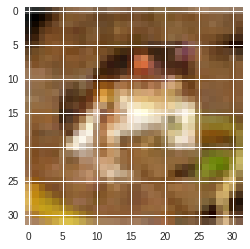

In [13]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

x, y = next(iter(train_ds))
    
imshow(x)
print(classes[y])


In [0]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [17]:
model = SimpleNet([32*32*3, 40, 20, 10])
print(model)

SimpleNet(
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
)


In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    '''https://github.com/fastai/fastai_v1/blob/master/dev_nb/001a_nn_basics.ipynb'''
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    '''https://github.com/fastai/fastai_v1/blob/master/dev_nb/001a_nn_basics.ipynb'''
    for epoch in range(epochs):
        
        # Fit model to training data
        model.train()
        losses,nums = zip(*[loss_batch(model, loss_func, xb.cuda(), yb.cuda(), opt) for xb,yb in train_dl])
        train_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
                    
        # Calculate loss on validation set
        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[loss_batch(model, loss_func, xb.cuda(), yb.cuda())
                                for xb,yb in valid_dl])
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

        print(f'Epoch {epoch}. Training loss: {train_loss}. Validation loss: {val_loss}.')

In [0]:
opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

In [0]:
import time

In [21]:
start_time = time.time()
model.cuda()
fit(3, model, loss_func, opt, train_dl, valid_dl)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

Epoch 0. Training loss: 2.0469409800720215. Validation loss: 2.22978109375.
Epoch 1. Training loss: 2.072466404953003. Validation loss: 2.1612657694244386.
Epoch 2. Training loss: 2.1009985132598876. Validation loss: 2.1094183145141603.
--- 50.404780626297 seconds ---


In [0]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))
    
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [0]:
model = ConvNet2([3, 20, 40, 80], 10).cuda()

In [26]:
start_time = time.time()
fit(1, model, loss_func, opt, train_dl, valid_dl)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

Epoch 0. Training loss: 2.3044129958343507. Validation loss: 2.3044130042266846.
--- 18.466835975646973 seconds ---


In [0]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / (self.stds + 1e-5) *self.m + self.a
    
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [0]:
model = ConvBnNet([10, 20, 40, 80, 160], 10).cuda()

In [36]:
start_time = time.time()
fit(1, model, loss_func, opt, train_dl, valid_dl)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

Epoch 0. Training loss: 2.7670013973236083. Validation loss: 5.091566016387939.
--- 26.17133903503418 seconds ---


In [0]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [0]:
model = ConvBnNet2([10, 20, 40, 80, 160], 10).cuda()

In [39]:
start_time = time.time()
fit(1, model, loss_func, opt, train_dl, valid_dl)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

Epoch 0. Training loss: 2.571094758758545. Validation loss: 2.591096190948486.
--- 32.87595057487488 seconds ---


In [0]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)
    
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [0]:
model = Resnet([10, 20, 40, 80, 160], 10).cuda()

In [44]:
start_time = time.time()
fit(1, model, loss_func, opt, train_dl, valid_dl)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

Epoch 0. Training loss: 3.024303991622925. Validation loss: 3.0820849451446533.
--- 42.68823194503784 seconds ---


In [0]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [0]:
model = Resnet2([16, 32, 64, 128, 256], 10, 0.2).cuda()

In [0]:
opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss()

In [48]:
start_time = time.time()
fit(1, model, loss_func, opt, train_dl, valid_dl)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

Epoch 0. Training loss: 2.316374485092163. Validation loss: 6456.414556367187.
--- 59.9325168132782 seconds ---


In [51]:
start_time = time.time()
fit(5, model, loss_func, opt, train_dl, valid_dl)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

Epoch 0. Training loss: 1.5029451962280274. Validation loss: 1.1253611541748048.
Epoch 1. Training loss: 1.2606730559539794. Validation loss: 3.089267018966675.
Epoch 2. Training loss: 1.1255294267654419. Validation loss: 1.0127433842658997.
Epoch 3. Training loss: 0.9518194551086426. Validation loss: 0.686806518611908.
Epoch 4. Training loss: 0.853570230293274. Validation loss: 0.811681506652832.
--- 298.1899530887604 seconds ---


In [0]:
def predict(m, dl, as_torch = False):
    
    m.eval()
    preds = []
    ys = []
    
    with torch.no_grad():     
        for xb, yb in dl:
            preds.append(m(xb.cuda()))
            ys.append(yb.cuda())
            
    preds = torch.cat(preds, dim = 0)
    ys = torch.cat(ys, dim = 0)
    
    if ~as_torch: 
        preds = np.array(preds)
        ys = np.array(ys)
            
    return preds, ys

In [0]:
def get_val_acc(m, dl):
    log_probs, targets = predict(m, valid_dl)
    preds = np.argmax(log_probs, axis = 1)
    return sum(preds == targets) / targets.shape[0]

In [89]:
get_val_acc(model, valid_dl)

0.80586

In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    '''https://github.com/fastai/fastai_v1/blob/master/dev_nb/001a_nn_basics.ipynb'''
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    '''https://github.com/fastai/fastai_v1/blob/master/dev_nb/001a_nn_basics.ipynb'''
    
    fig, axes = plt.subplots(nrows = 1, ncols = epochs, figsize = (epochs*4, 4))
    for epoch in range(epochs):
        
        # Fit model to training data
        model.train()
        losses,nums = zip(*[loss_batch(model, loss_func, xb.cuda(), yb.cuda(), opt) for xb,yb in train_dl])
        train_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
        
        axes[epoch].plot(np.arange(len(train_dl)), np.array(losses))
                    
        # Calculate loss on validation set
        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[loss_batch(model, loss_func, xb.cuda(), yb.cuda())
                                for xb,yb in valid_dl])
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

        print(f'Epoch {epoch}. Training loss: {train_loss}. Validation loss: {val_loss}.')
    plt.show()

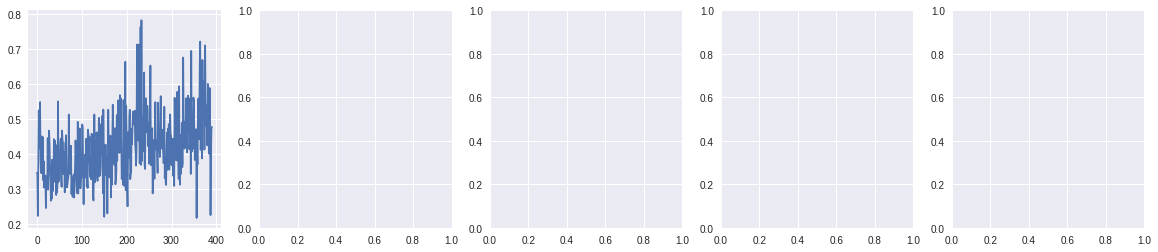

Epoch 0. Training loss: 0.4181226163291931. Validation loss: 0.3140957693386078.
Epoch 1. Training loss: 0.3200704450416565. Validation loss: 0.17696702772140502.
Epoch 2. Training loss: 0.24708212211608888. Validation loss: 0.14556892649173736.
Epoch 3. Training loss: 0.18875140435218812. Validation loss: 0.14888816385030745.
Epoch 4. Training loss: 0.14976925646305084. Validation loss: 0.12909435069799424.
--- 304.32636761665344 seconds ---


In [113]:
start_time = time.time()
fit(5, model, loss_func, opt, train_dl, valid_dl)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

Epoch 0. Training loss: 0.12467884772777557. Validation loss: 0.09054129659533501.
Epoch 1. Training loss: 0.10937391487598419. Validation loss: 0.08216328085422515.


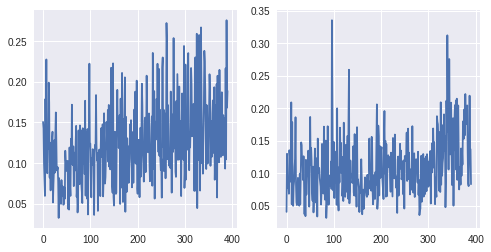

--- 122.08737516403198 seconds ---


In [123]:
start_time = time.time()
fit(2, model, loss_func, opt, train_dl, valid_dl)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

In [124]:
get_val_acc(model, valid_dl)

0.97244